# Machine Learning in Python - Workshop 5

# 1. Setup


## 1.1 Packages

In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [2]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

---

## 1.2 Helper Functions

Below are two helper functions we will be using in this workshop.

In [3]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

---

## 1.3 Data

The data for this week's workshop comes from the Elements of Statistical Learning textbook. The data originally come from a study by Stamey et al. (1989) in which they examined the relationship between the level of prostate-specific antigen (`psa`) and a number of clinical measures in men who were about to receive a prostatectomy. The variables are as follows,

* `lpsa` - log of the level of prostate-specific antigen
* `lcavol` - log cancer volume
* `lweight` - log prostate weight
* `age` - patient age
* `lbph` - log of the amount of benign prostatic hyperplasia
* `svi` - seminal vesicle invasion
* `lcp` - log of capsular penetration
* `gleason` - Gleason score
* `pgg45` - percent of Gleason scores 4 or 5
* `train` - test / train split used in ESL

These data are available in `prostate.csv` which is provided with this worksheet. 

In [4]:
prostate = pd.read_csv('prostate.csv')
prostate

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


As before we will begin by constructing a pairs plot of our data and examining the relationships between our variables.

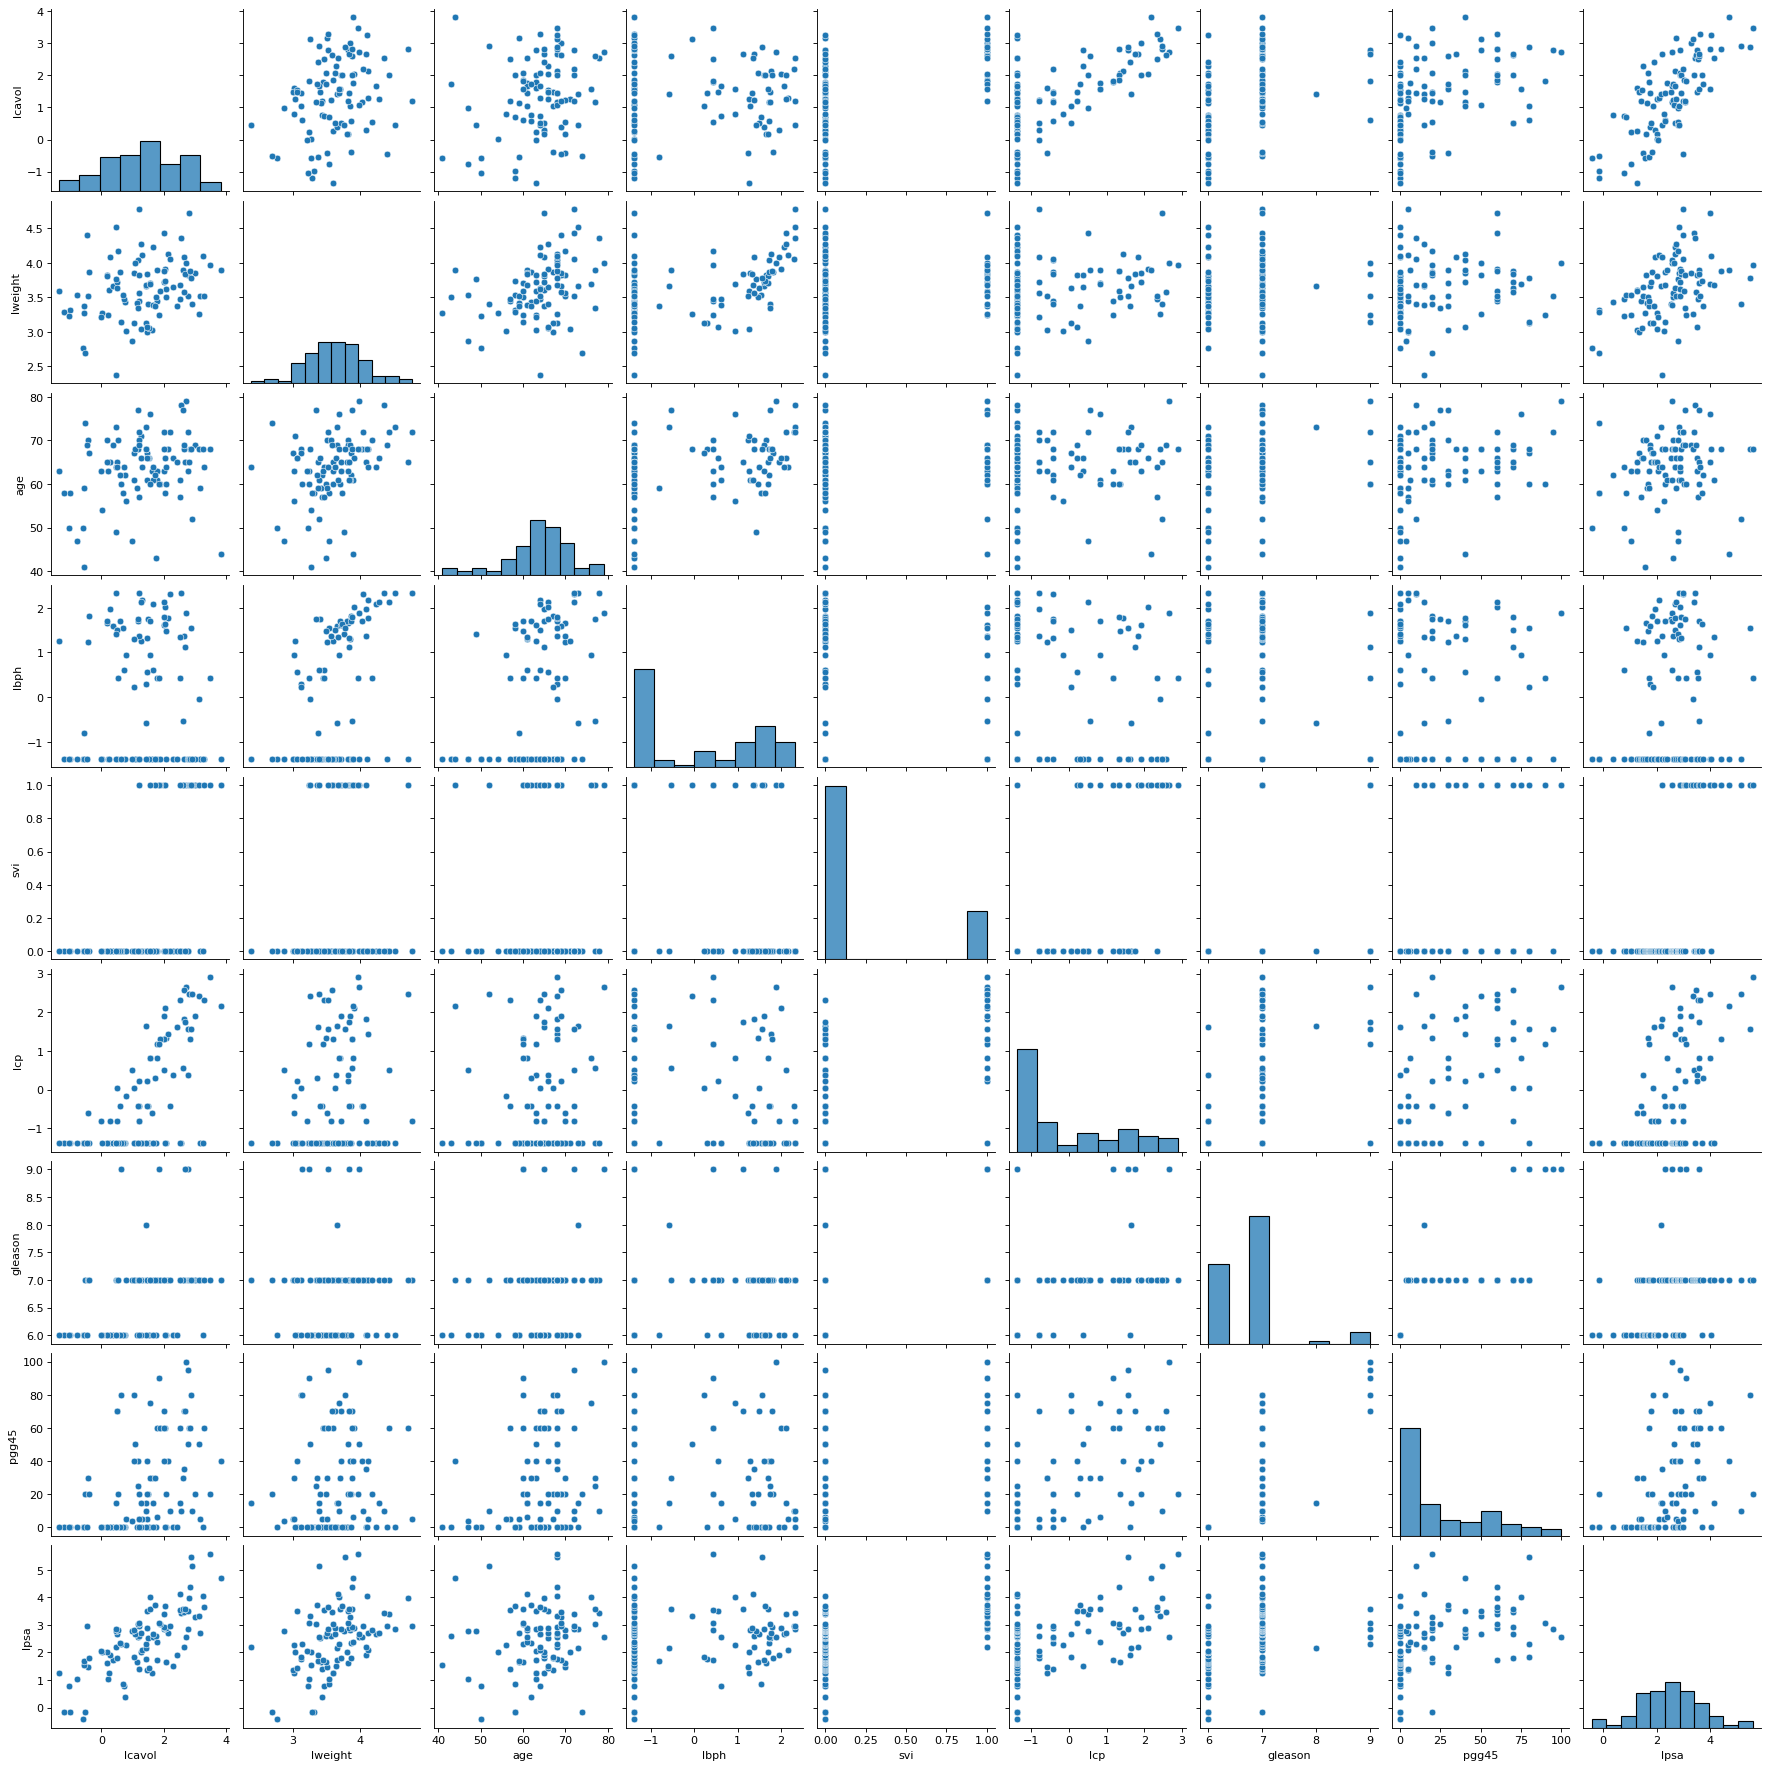

In [5]:
sns.pairplot(data=prostate)

---

### &diams; Exercise 1

Are there any interesting patterns in these data? Specifically, your answer should address,
* Do any of our variables appear to be categorical / ordinal rather than numeric?
* Which variable appears likely to have the strongest relationship with `lpsa`?

* *`svi` and `gleason` both appear to be categorical, with `gleason` in particular appearing to be oridinal.*

* *`lcavol` and `lcp` seem to have the potentially linear relationships with `lpsa`.*

---

### &diams; Exercise 2

Why do you think we are exploring the relationship between these variables and `lpsa` (log of psa) rather than just psa?

*`psa` is very right skewed, transforming it in this way gives a symmetric and more "normal" distribution.*

---

## 1.4 Validation Set

For these data we have already been provided a column to indicate which values should be used for the training set and which for the validation set. This is encoded by the values in the `train` column - we can use these columns to separate our data and generate our training data: `X_train` and `y_train` as well as our test data `X_test` and `y_test`. As we will also need the complete data set we will also construct `X` and `y`, which contain all 97 observations but without the `train` column.

In [6]:
# Create train and validate data frames
train = prostate.query("train == 'T'").drop('train', axis=1)
validate = prostate.query("train == 'F'").drop('train', axis=1)

In [7]:
# Training data
X_train = train.drop(['lpsa'], axis=1)
y_train = train.lpsa

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (67, 8)
y_train: (67,)


In [8]:
# Validation data
X_test = validate.drop('lpsa', axis=1)
y_test = validate.lpsa

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (30, 8)
y_test: (30,)


In [9]:
# Complete data
X = prostate.drop(['lpsa','train'], axis=1)
y = prostate.lpsa

print("X:", X.shape)
print("y:", y.shape)

X: (97, 8)
y: (97,)


---

## 1.5 Baseline model

Our first task is to fit a baseline model which we will be able to use as a point of comparison for our subsequent models. A good candidate for this is a simple linear regression model that includes all of our features.

In [10]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train, y_train)

We can extract the coefficients for the model, which correspond to the variables: `intercept`, `lcavol`, `lweight`, `age`, `lbph`, `svi`, `lcp`, `gleason`, and `pgg45` respectively.

In [11]:
get_coefs(lm)

array([ 0.42917013,  0.57654319,  0.61402   , -0.01900102,  0.14484808,
        0.73720864, -0.20632423, -0.02950288,  0.00946516])

These coefficients have the typical regression interpretation, e.g. for each unit increase in `lcavol` we expect `lpsa` to increase by 0.577 on average. These values are not of particular interest for us for this particular problem as we are more interested in the predictive properties of our model(s). To evaluate this we will use the `model_fit` helper function defined above. 

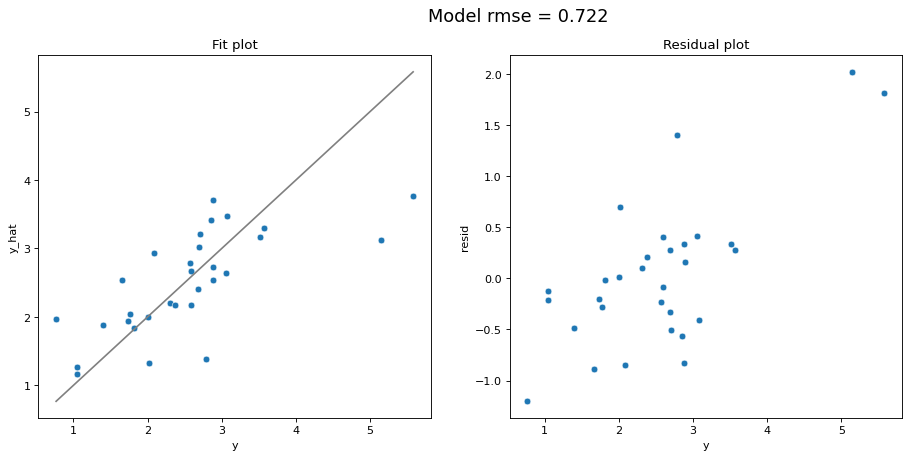

0.7219930785731958

In [12]:
model_fit(lm, X_test, y_test, plot=True)

Primarily we will use this function to obtain the rmse of our model using the validation data (`X_test` and `y_test`). Note that we fit the model using the training data (`X_train` and `y_train`). We have also included a fit ($y$ vs $\hat{y}$) and resid ($y$ vs $y-\hat{y}$) plot of these results.

---

### &diams; Exercise 3

Based on these plots do you see anything in the fit or residual plot that is potentially concerning?

*The model appears to be having difficulties with the smallest and largest values of `lpsa`, i.e. small values are over-predicted 
(negative residuals) while larger values are underpredicted (positive residuals).*

---

### &diams; Exercise 4

Would you expect the rmse of the model to be better or worse when using the training data (compared to the validation data)? Check your answer using the `model_fit` function.

*Generally, the test data should have a worse rmse than the training data since fitting the least squares estimate is 
equivalent to minimizing the rmse. The training fit has a better rmse than our testing fit based on the results
below.*



In [13]:
model_fit(lm, X_train, y_train)

0.662721486039448

---

## 1.6 Standardization

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\beta$. While not particularly bad, our baseline model had $\beta$s that ranged from the smallest at 0.0095 to the largest at 0.737 which is about a 78x difference in magnitude. This difference can be made even worse if we were to change the units of one of our features, e.g. changing a measurement in kg to grams would change that coefficient by 1000 which has no effect on the fit of our linear regression model (predictions and other coefficients would be unchanged) but would have a meaningful impact on the estimates given by a Ridge or Lasso regression model, since that coefficient would now dominate the penalty term.

To deal with this issue, the standard approach is to center and scale *all* features to a common scale before fitting one of these models. The typical scaling approach is to subtract the mean of each feature and then divide by its standard deviation - this results in all feature columns having a mean of 0 and a variance of 1. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.

Using sklearn we can perform this transformation using the `StandardScaler` transformer from the `preprocessing` submodule.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
S = StandardScaler().fit(X)

Once fit, we can examine the values used for the scaling by checking the `mean_` and `var_` attributes of the transformer.

In [16]:
S.mean_

array([ 1.35000958,  3.62894266, 63.86597938,  0.10035561,  0.21649485,
       -0.17936558,  6.75257732, 24.3814433 ])

In [17]:
S.var_

array([1.37483540e+00, 1.81644057e-01, 5.48583271e+01, 2.08314048e+00,
       1.69624827e-01, 1.93494631e+00, 5.16101605e-01, 7.87266872e+02])

Keep in mind, that the training, testing, and validation sets will not necessarily have the same feature column means and standard deviations - as such it is important that we choose a consistent set of values that are used for all of the data. In other words, be careful to not expect that `StandardScaler().fit_transform(X_train)` and  `StandardScaler().fit(X).transform(X_train)` will give the same answer. The best way to avoid this issue is to include the `StandardScaler` in a modeling pipeline for your data.

---

### &diams; Exercise 5

Explain why scaling `y`, `y_train`, or `y_test` is not necessary.

*Ridge regression (and Lasso) only shrinks the features - there is no penalty on the scale of `y`. 
Additionally, scaling `y` would change the $\beta$s but in a systematic fashion that will 
be accounted for by a change in  $\alpha$, canceling any effect.*

---

### &diams; Exercise 6

What are the units of the transformed features in `StandardScaler().fit_transform(X_train)`? 

*The transformed features are unitless, regardless of their original units.*

---

## 1.7 Scaled Linear Regression

Now that we have scaled the data, let us fit another simple linear regression model using these scaled features. 

In [18]:
lm_scaled = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X_train, y_train)

Once fit we can extract the model coefficients and calculate the validation rmse,

In [19]:
get_coefs(lm_scaled)

array([ 2.45234509,  0.71104059,  0.29045029, -0.14148182,  0.21041951,
        0.30730025, -0.28684075, -0.02075686,  0.27526843])

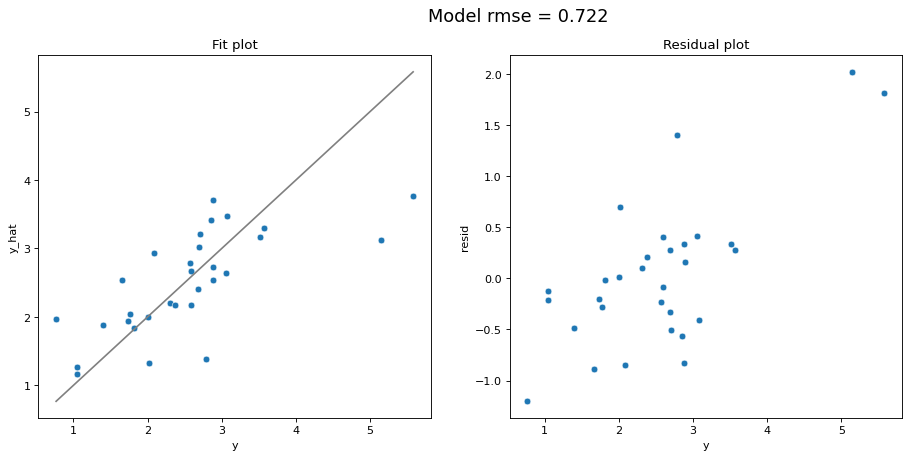

0.7219930785731954

In [20]:
model_fit(lm_scaled, X_test, y_test, plot=True)

---

### &diams; Exercise 7

Using this new model what has changed about our model results? Comment on both the model's coefficients as well as its predictive performance.

*Rescaling the features causes the  𝛽 s to change but the model is effectively the same and has the 
same predictive performance as the previous model.*

--- 

# 2. Ridge Regression

Ridge regression is a natural extension to linear regression which introduces an $\ell_2$ penalty on the coefficients to a standard least squares problem. Mathematically, we can express this as the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

The `Ridge` model is provided by the `linear_model` submodule and requires a single parameter `alpha` which determines the tuning parameter that adjusts the weight of the $\ell_2$ penalty.

In [21]:
from sklearn.linear_model import Ridge

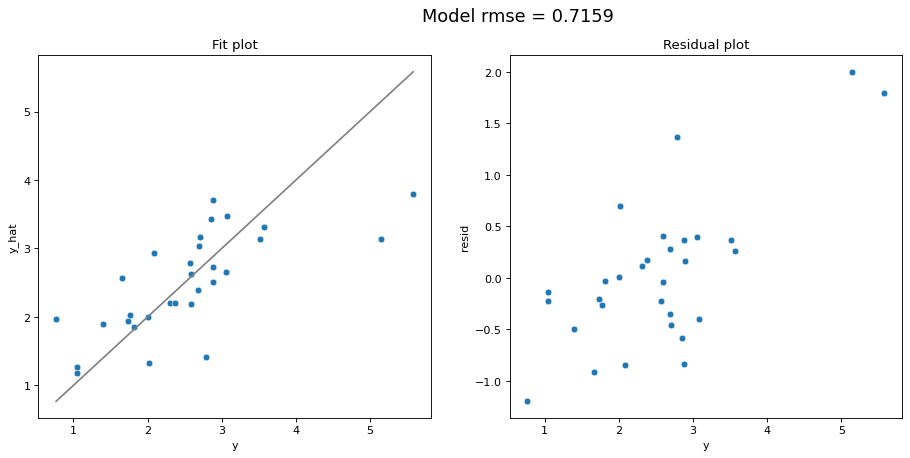

0.7159032220617371

In [22]:
r = make_pipeline(
    StandardScaler(),
    Ridge(alpha=1)
).fit(X_train, y_train)

model_fit(r, X_test, y_test, plot=True)

---

### &diams; Exercise 8

Adjust the value of `alpha` in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the rmse change?

*Model fit does not change much but rmse improves as alpha is increased until around $\alpha=20$.*



---

### &diams; Exercise 9

In Section 1.4 we mentioned the importance of scaling features before fitting a Ridge regression model. The code below fits the Ridge model to the untransformed training data - repeat Exercise 8 using these data. How does the model fit change as alpha changes? How does the rmse change? How does the models performance compare to the previous model?

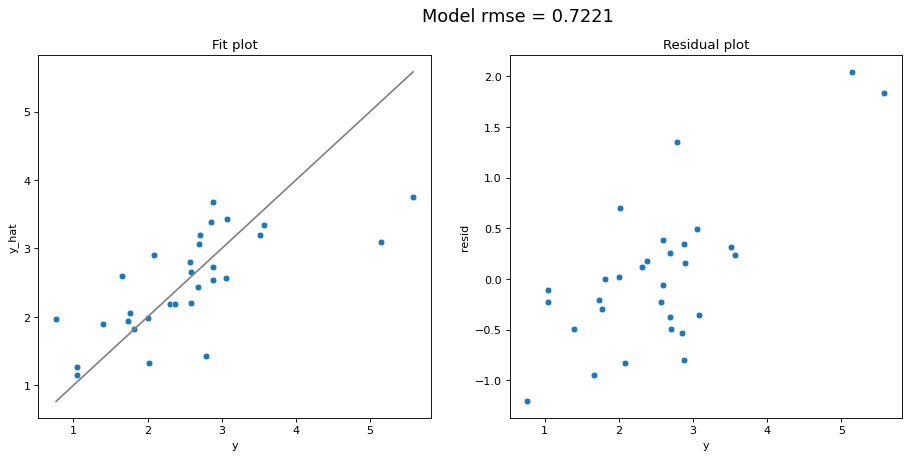

0.7220807306906398

In [23]:
r_wo_scale = make_pipeline(
    Ridge(alpha=1)
).fit(X_train, y_train)

model_fit(r_wo_scale, X_test, y_test, plot=True)

*Fit is roughly equivalent and does not change significantly, rmse gets worse as alpha increases,
$\alpha=0$ gives the best performance which is worse than performance of the previous model.*



---

## 2.1 Ridge $\beta$s as a function of $\alpha$
 
Finally, one of the useful ways of thinking about the behavior of Ridge regression models is to examine the relationship between our choice of $\alpha$ and the resulting $\beta$s relative to the results we would have obtained from the linear regression model. Since Ridge regression is equivalent to linear regression when $\alpha=0$ we can see that as we increase the value of $\alpha$ we are shrinking all of the $\beta$s towards 0 asymptotically.


In [24]:
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    ).fit(X_train, y_train)
    
    # We drop the intercept as it is not included in Ridge's l2 penalty and hence not shrunk
    betas.append(get_coefs(m)[1:]) 
    rmses.append(model_fit(m, X_test, y_test))

In [25]:
res = pd.DataFrame(
    data = betas,
    columns = X.columns # Label columns w/ feature names
).assign(
    alpha = alphas,
    rmse = rmses
).melt(
    id_vars = ('alpha', 'rmse')
)

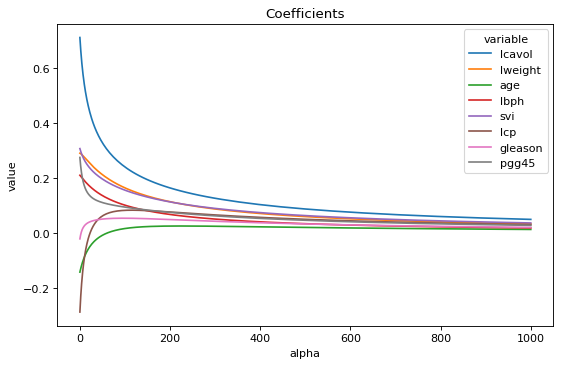

In [26]:
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.show()

---

### &diams; Exercise 10

Based on this plot, which variable(s) seem to be the most important for predicting `lpsa`. 
*Hint* - think about what the degree of shrinkage towards 0 means in this context. 

*It appears that `lvavol` and `age` have the least amount of shrinkage applied and are therefore likely
to be the most important variable for this model. Additionally, if we consider the area around $\alpha=20$
we also see that `lcp` has less shrinkage.*

---

## 2.2 Tuning with GridSearchCV

The $\alpha$ in the Ridge regression model is another example of a hyperparameter, and just like the degree in a polynomial model we can use cross validation to attempt to identify the optimal value for our data. As with the polynomial models from last week we will start by using `GridSearchCV` to employ 5-fold cross validation to determine an optimal $\alpha$.

In [27]:
alphas = np.linspace(0, 15, num=151)

In [28]:
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

Note that we are passing `sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)` to the `cv` argument rather than leaving it to its default. This is because, while not obvious, the prostate data is structured (sorted by `lpsa` value) and this way we are able to ensure that the folds are properly shuffled. Failing to do this causes *very* unreliable results from the cross validation process.

Once fit, we can examine the results to determine what value of $\alpha$ was chosen as well as examine the calculated mean of the rmses.

In [29]:
print(gs.best_params_)

{'ridge__alpha': 6.300000000000001}


To evaluate this model we can access the `best_estimator_` model object and use it to obtain an rmse for our validation data.

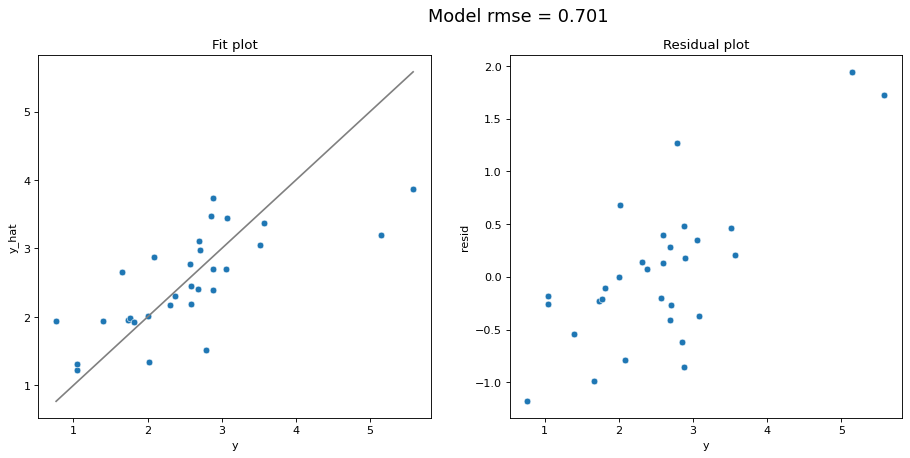

0.7010036592591792

In [30]:
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

---

### &diams; Exercise 11

How does this model compare to the performance of our baseline model? Is it better or worse?

*The model performs better than our baseline model (linear regression).*

---

### &diams; Exercise 12

How do the model coefficient for this model compare to the base line model? *Hint* - be careful about which baseline model you compare with.

*Coefficients are smaller, closer to 0 (compare to `lm_scaled` not `lm`)*

---

To further explore this choice of $\alpha$, we can collect relevant data about the folds and their performance from the `cv_results_` attribute. In this case we are particularly interested in examining the `mean_test_score` and the `split#_test_score` keys since these are used to determine the optimal $\alpha$.

In the code below we extract these data into a data frame by selecting our columns of interest along with the $\alpha$ values used (and transform negative rmse values into positive values).

In [31]:
cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
)

This data frame can then be used to plot $\alpha$ against the mean root mean squared value over the 5 folds, to produce the following plot.

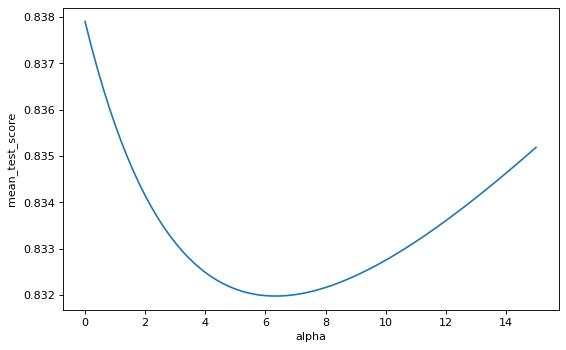

In [32]:
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
plt.show()

This plot shows that the value 6.4 is obtained as the minimum of this curve. However, this plot gives us an overly confident view of this choice of this particular value of $\alpha$. Specifically, if instead of just plotting the mean rmse, we also examine the variablility of that estimate as well as examine the $\alpha$ vs rmse curve of each fold we see that these estimates are far noisier than they first appeared and we should take the value $\alpha = 6.4$ with a grain of salt.

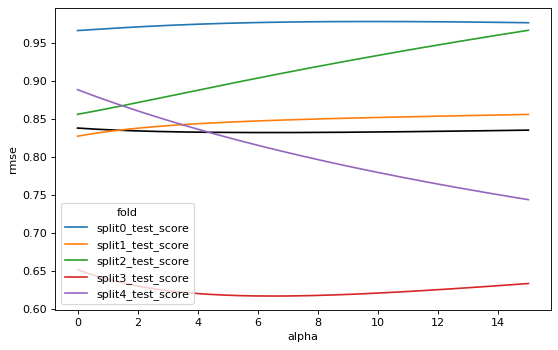

In [33]:
d = cv_res.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='rmse'
)

sns.lineplot(x='alpha', y='rmse', color='black', ci = None, data = d)  # Plot the mean rmse +/- the std dev of the rmse.
sns.lineplot(x='alpha', y='rmse', hue='fold', data = d) # Plot the curves for each fold
plt.show()

In the plot above the black line shows the mean rmse across the folds (this is the same curve as shown in the previous plot) and the gray interval indicates + and - 1 standard deviation of the rmses. The other colored cuves shows the rmse curve for each of the different folds.

---

### &diams; Exercise 13

Why do you think that our cross validation results are unstable?

*The most likely cause is due to the relatively small size of the data, with 5 fold cross validation 
within each fold the training and validation sizes are 53 and 14 observations respectively.*



---

## 2.3 Tuning with RidgeCV

Because the process of identifying the value of $\alpha$ is critical to most uses of Ridge regression, sklearn provides a helpful function called `RidgeCV` which combines `Ridge` with `GridSearchCV`. We import this function from `linear_model` and fit it in the same way.

In [34]:
from sklearn.linear_model import RidgeCV

In [35]:
r_cv = RidgeCV(
    alphas = np.linspace(0.1, 15, num=150), # RidgeCV does not allow alpha=0 for some reason
    scoring = "neg_root_mean_squared_error"
).fit(X_train, y_train)

In [36]:
r_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas = np.linspace(0.1, 15, num=150), # RidgeCV does not allow alpha=0 for some reason
        scoring = "neg_root_mean_squared_error"
    )
).fit(X_train, y_train)

The resulting model object now has the "optimal" value of $\alpha$ stored in the `alpha_` attribute which we can access directly.

In [37]:
r_cv.named_steps["ridgecv"].alpha_

3.6

Additionally, the returned object can be used like any other model object to obtain predictions for the fitted model using this value of $\alpha$.

In [38]:
model_fit(r_cv, X_test, y_test)

0.7060258433830874

---

### &diams; Exercise 14

This model seems to have arrived at a different optimal value for $\alpha$ compared to using `GridSearchCV` and it also has a different (slightly worse) rmse. Review the documentation for `RidgeCV`. Can you explain this discrepancy?

*RidgeCV uses generalized cross validation rather than k-fold cv by default.*


---

### &diams; Exercise 15

Refit the model using the RidgeCV in such a way that you obtain a result similar to what was obtained by `GridSearchCV` (in terms of the optimal $\alpha$ and validation rmse).

In [39]:
r_cv2 = make_pipeline(
    StandardScaler(),
    RidgeCV(
        alphas=np.linspace(0.1, 15, num=150), 
        cv=KFold(5, shuffle=True, random_state=1234),
        scoring = "neg_root_mean_squared_error"
    )
).fit(X_train, y_train)

print( "alpha:", r_cv2.named_steps["ridgecv"].alpha_)
print( "rmse:", model_fit(r_cv2, X_test, y_test) )

alpha: 5.8
rmse: 0.7016718631100778


--- 

# 3. The Lasso

The Lasso is a related modeling approach to Ridge regression, but instead uses an $\ell_1$ penalty on the coefficients. Mathematically, we can express this model as the solution of the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert_2^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1 $$ 

As with the other models from this worksheet, the `Lasso` model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty.

In [40]:
from sklearn.linear_model import Lasso

In [41]:
l = make_pipeline(
    StandardScaler(),
    Lasso(alpha=0.15)
).fit(X_train, y_train)

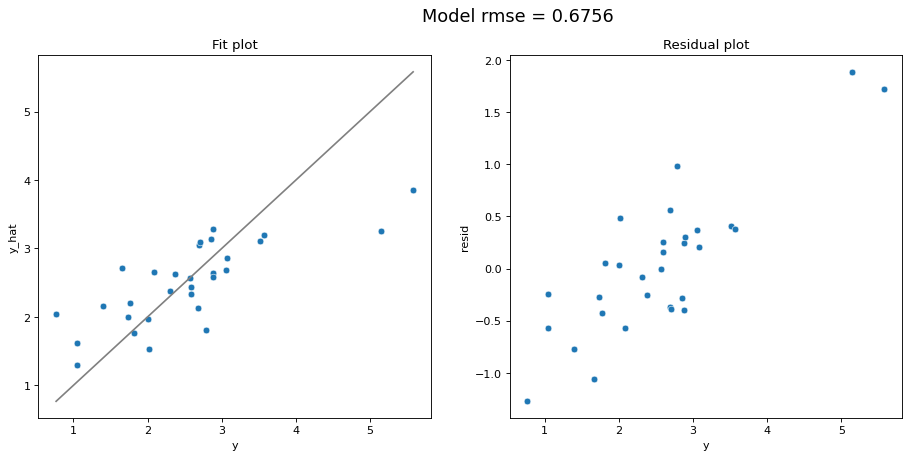

lasso rmse: 0.6755984657058376
lasso coefs: [2.45234509 0.56476334 0.20956522 0.         0.05792154 0.13596345
 0.         0.         0.03500349]


In [42]:
print("lasso rmse:", model_fit(l, X_test, y_test, plot=True))
print("lasso coefs:", get_coefs(l))

---

### &diams; Exercise 16

Adjust the value of `alpha` in the cell above and rerun it. How does the model fit change as alpha changes? How does the validation rmse change?

*Large values of  $\alpha$ negatively impact the model fit as the  𝛽 s are shrunk to 0, values around 0.1 to 0.2 produce an improved rmse*

---

## 3.1 Lasso $\beta$s as a function of $\alpha$

As with Ridge regression we can examine the values of $\beta$ we obtain as tuning parameter $\alpha$ is adjusted. 


In [43]:
alphas = np.linspace(0.01, 1, num=100)
betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Lasso(alpha=a)
    ).fit(X_train, y_train)

    # Again ignore the intercept since it isn't included in the penalty
    betas.append(get_coefs(m)[1:])  
    rmses.append(model_fit(m, X_test, y_test))

res = pd.DataFrame(
    data = betas,       # Coefficients
    columns = X.columns # Coefficient names
).assign(
    alpha = alphas,     # Add alpahs
    rmse = rmses        # Add validation rmses
).melt(
    id_vars = ('alpha', 'rmse') # Move columns into the rows
)

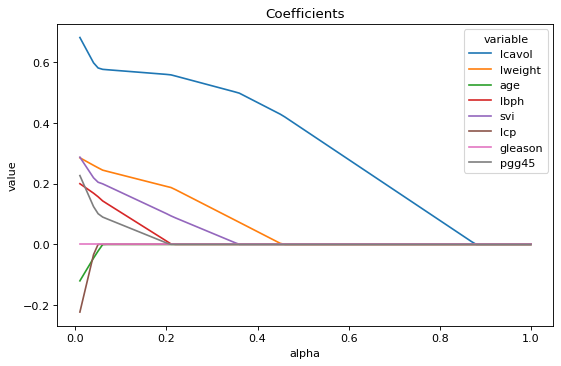

In [44]:
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.show()

---

### &diams; Exercise 17

How does the relationship between the $\beta$s and $\alpha$ differ from what we saw with the Ridge regression results. 

*Values of $\alpha$ are much smaller - we see more rapid shrinkage in general and coefs are directly shrunk to 0.*



---

### &diams; Exercise 18

Based on this plot, which variable(s) seem to be the most important for predicting `lpsa`. *Hint* - think about what the degree of shrinkage towards 0 means in this context. How does this compare to your answer from the ridge regression model?

*Based on the variables that are not shrunk to 0 - `lcavol` seems like the most important, followed by `lweight`.*

---

## 3.2 Tuning Lasso

We can again use the `GridSearchCV` function to tune our Lasso model and optimize the $\alpha$ hyperparameter. We avoid using $\alpha = 0$ as this causes a warning due to the fitting method (coordinate descent) not converging well without regularization (the $\ell_1$ penalty here).

In [45]:
alphas = np.linspace(0.01, 1, num=100)

l_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Lasso()
    ),
    param_grid={'lasso__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

In [46]:
print( "best alpha:", l_gs.best_params_['lasso__alpha'])
print( "best rmse :", l_gs.best_score_ * -1)
print( "validation rmse:", model_fit(l_gs.best_estimator_, X_test, y_test) )

best alpha: 0.01
best rmse : 0.8418522162867372
validation rmse: 0.7061975744044543


Worryingly, the chosen alpha is the smallest value provided to our grid search, and hence it has selected the model closest to a linear regression model. We can investigate this further by plotting $\alpha$ versus the `mean_test_score` values from the `cv_results_` attribute. 

In [47]:
l_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * l_gs.cv_results_['mean_test_score'],           # mean of the rmse over the folds
    rmse_se = l_gs.cv_results_['std_test_score'] / np.sqrt(l_gs.n_splits_), # standard error of the rmse
)

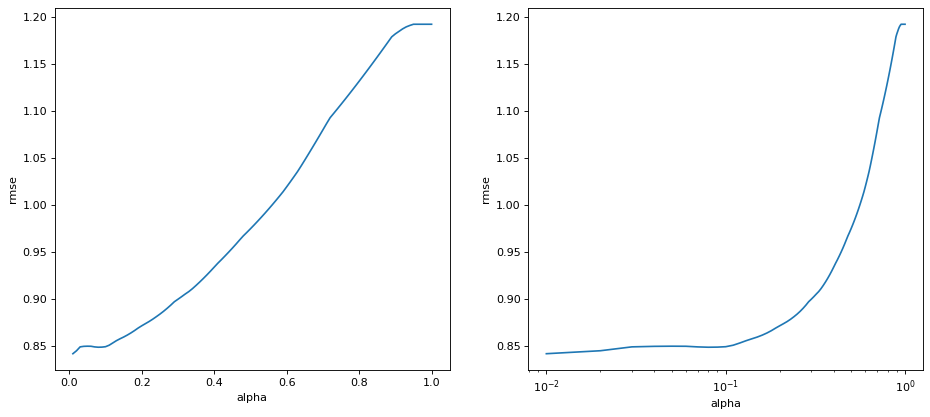

In [48]:
plt.figure(figsize=(14, 6))
        
plt.subplot(121)
sns.lineplot(x='alpha', y='rmse', data=l_cv_res)

plt.subplot(122)
sns.lineplot(x='alpha', y='rmse', data=l_cv_res).set_xscale('log')

In this case it appears that the model's rmses nearly monotonically increase as $\alpha$ increases. This indicates that the CV proceedure is exhibiting a preference for the linear regression mode, i.e. a lasso model with no shrinkage. We can check this explicitly by fitting the `LinearRegression` with `GridSearchCV` and comparing the cross validation rmse, this is necessary because our previous modeling did not use any CV to calculate the rmse.

In [49]:
linearr = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(
    X_train, y_train
)

In [52]:
l_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * linearr.cv_results_['mean_test_score'],           # mean of the rmse over the folds
    rmse_se = linearr.cv_results_['std_test_score'] / np.sqrt(linearr.n_splits_), # standard error of the rmse
)

AttributeError: 'numpy.float64' object has no attribute 'cv_results_'

In this case the linear regression model does produce a smaller mean rmse than any of the Lasso models. This suggests our choice of model should just be the original linear regression model.

*Aside* - However, if we examine these plots closesly, values of $\alpha$ between 0.01 and 0.1 have very similar mean rmses and there is uncertainty in our estimates of these rmses based on the cross validation folds and the size of our data. One of the suggestions employed by Hastie, et al. in their `glmnet` R package is instead of using the $\alpha$ with the smallest mean rmse to instead use the largest value of $\alpha$ that has an error metric (rmse) that is within 1 standard *error* of the minimum value of the error metric (rmse). We can find this value using the `l_cv_res` data frame we previously constructed.

In [50]:
i = l_cv_res.rmse.idxmin()

min_rmse = l_cv_res.rmse[i]       # Smallest rmse
min_rmse_se = l_cv_res.rmse_se[i] # Std error of the smallest rmse

sub = l_cv_res.rmse <= min_rmse + min_rmse_se # Find rmses w/in 1se of the min + se

alpha_1se = l_cv_res.alpha[ sub ].max() # Find the largest alpha

alpha_1se

0.26

While this approach seems plausible / practical, it should be treated as at best a heuristic as I have not been able to track down any theoretical support for it. Note that we could also employ this strategy even if the minimal $\alpha$ had not been approximately 0 and it is still likely to be helpful as any increase in $\alpha$ is likely to reduce the number of coefficients in the final model. 

---

### &diams; Exercise 19

If you were to use the $\alpha_\text{1se} = 0.26$ which variables would be excluded from the model? 

*`age`, `lbph`, `lcp`, `gleason`, `pgg45` would all have coefficients of 0 and hence be excluded from the model.*

---

### &diams; Exercise 20

If you were to use the $\alpha_{\text{1se}} = 0.26$ what would the validation rmse be for this model? How does this compare to the other models we've examined so far? Why might we still prefer this model over the linear regression or Ridge model?

*This model has slightly better performance than the Linear Regression model (0.722) but worse than 
the Ridge model (0.700), however we might prefer it as it is a far simpler model with fewer coefficients 
(only 4 including the intercept) than either of the alternatives.*

---

## 4 Concluding Remarks

It is important to notice that throughout the previous two sections we have taken great pains to avoid using our test data to in any way inform our choice of the tuning parameter. Instead, we have always used `KFold` with our training data to obtain the necessary metrics for optimizing the $\alpha$ hyperparameter. This would also have been possible using the complete data `X` and would have slightly improved our rmse estimates due to the slightly larger sample sizes in the test train splits but it would then mean were repeated using the validation data in the process of determining $\alpha$ which then puts us at risk for overfitting and therefore having an overly optimistic view of our model's uncertainty.  

---

## 5. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week05` assignment.

In [51]:
!jupyter nbconvert --to pdf mlp-week05.ipynb

[NbConvertApp] Converting notebook mlp-week05.ipynb to pdf
^C
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jupyter_core/application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nbconvert/nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nbconvert/nbconvertapp.py", line 524, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/Library/Frameworks/Python.frame

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a457ee97-62f6-4cfc-b8b4-762212228448' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>